In [9]:
# Function to generate wordclouds for each OEM
# Testing the change again
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS



In [10]:
df = pd.read_csv("ford_pass_car_apps_reviews.csv")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_name     10000 non-null  object
 1   review_text  9998 non-null   object
 2   review_date  10000 non-null  object
 3   rating       10000 non-null  int64 
 4   app_version  9667 non-null   object
 5   thumbs_up    10000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 468.9+ KB


In [18]:
# Remove stopwords from review_text
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already present
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english')).union({'app','car','Ford','Pass'})

def remove_stopwords(text):
    """Remove stopwords from text"""
    if isinstance(text, str):
        words = text.lower().split()
        return ' '.join([word for word in words if word not in stop_words])
    return text

# Apply stopword removal to review_text column
df['review_text'] = df['review_text'].apply(remove_stopwords)

print("Stopwords removed from review_text")
print("\nSample cleaned reviews:")
print(df['review_text'].head(3))

Stopwords removed from review_text

Sample cleaned reviews:
0                                                super
1    love new raptor tech it.....love definately co...
2                             happy interface explorer
Name: review_text, dtype: object


[nltk_data] Downloading package stopwords to /Users/rhea/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordclouds_by_oem(df, text_col, oem_col):
    """
    Generate and display larger wordclouds for each OEM in the dataset, removing stopwords and custom keywords.
    Args:
        df (pd.DataFrame): DataFrame containing reviews and OEM info
        text_col (str): Name of the column with review text
        oem_col (str): Name of the column with OEM info
    """
    # Add custom stopwords
    custom_stopwords = set(STOPWORDS).union({'app', 'car', 'work', 'vehicle','Ford'})
    oems = df[oem_col].unique()
    for oem in oems:
        text = " ".join(df[df[oem_col] == oem][text_col].astype(str))
        wc = WordCloud(width=1200, height=600, background_color='white', stopwords=custom_stopwords).generate(text)
        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for {oem}", fontsize=22)
        plt.show()

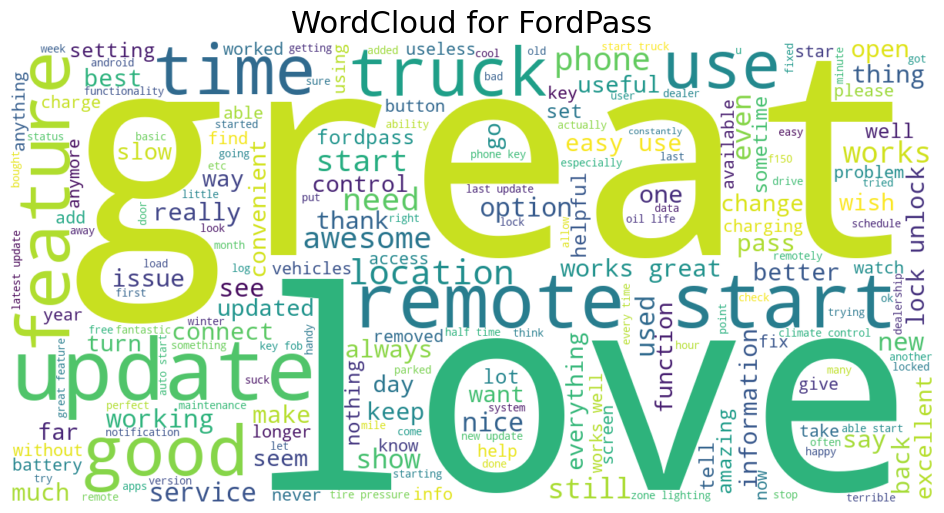

In [20]:
plot_wordclouds_by_oem(df,'review_text','app_name')

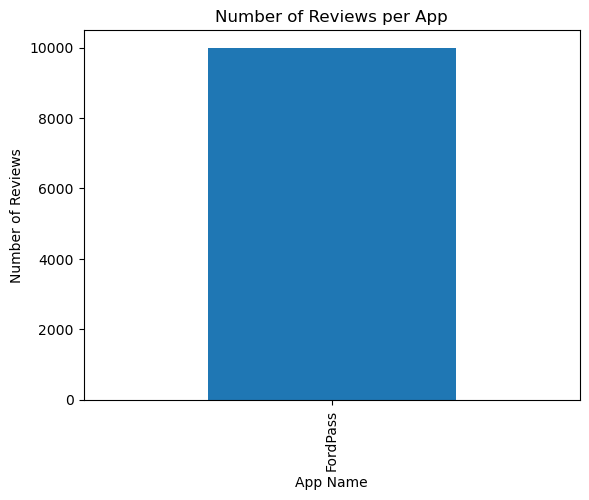

In [21]:
df['app_name'].value_counts().plot(kind='bar',xlabel='App Name', ylabel='Number of Reviews', title='Number of Reviews per App')
plt.show()

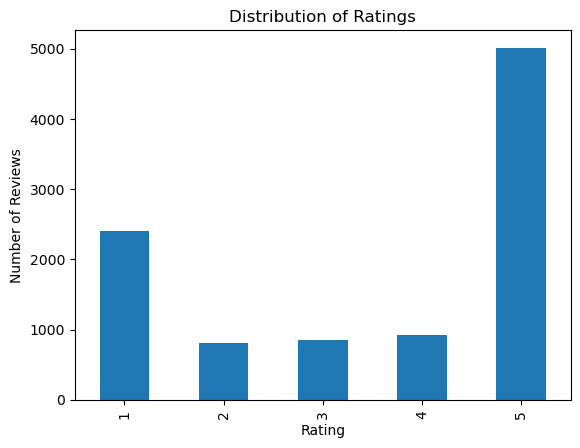

In [22]:
df['rating'].value_counts().sort_index().plot(kind='bar',xlabel='Rating', ylabel='Number of Reviews', title='Distribution of Ratings')
plt.show()

/var/folders/ys/rh_m_lvd12bc1py05dbf4g5m0000gn/T/ipykernel_60765/164534812.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()


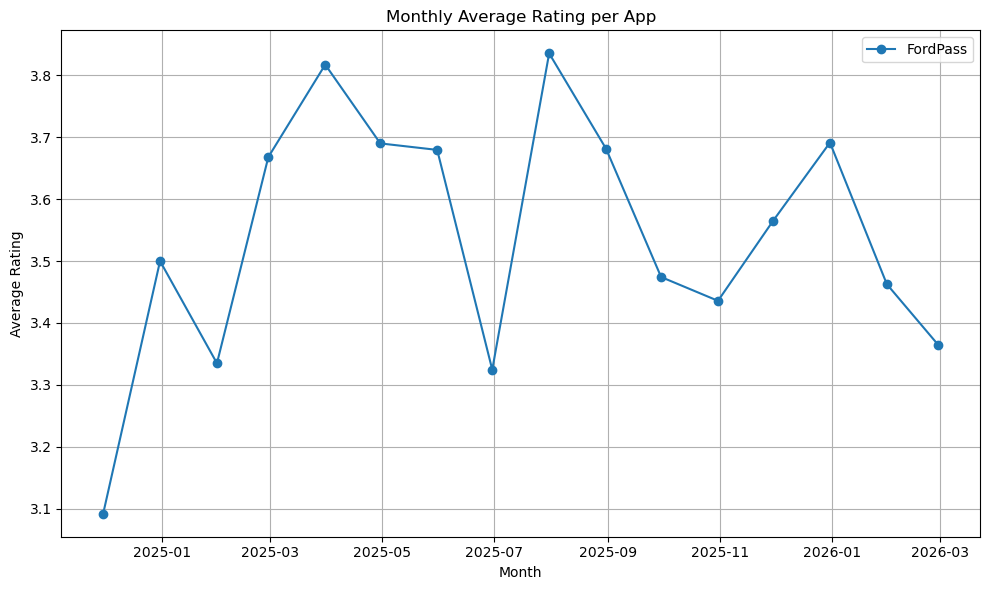

In [23]:
# Monthly average rating per app (line plot)
df['review_date'] = pd.to_datetime(df.get('review_date', df.get('at')), errors='coerce')
monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()
pivot = monthly.pivot(index='review_date', columns='app_name', values='rating')
plt.figure(figsize=(10,6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o', label=col)
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Monthly Average Rating per App')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Understanding Perplexity Scores in LDA

## What Are Perplexity Scores?

Perplexity scores measure how well an LDA model predicts unseen data. It's a metric that quantifies the model's uncertainty when encountering new documents.

- **Lower perplexity = Better model** — The model is more confident and accurate at predicting held-out text
- **Higher perplexity = Worse model** — The model struggles to predict new documents
- **Formula:** Perplexity = exp(-log likelihood / number of words)

## The Perplexity Formula

$$\text{Perplexity} = \exp\left(-\frac{\sum_{d=1}^{D} \log P(d)}{N}\right)$$

Where:
- **log P(d)** = log probability (log likelihood) of document d
- **D** = total number of documents
- **N** = total number of words across all documents
- **exp()** = exponential function (e^x)

**Simplified interpretation:**
$$\text{Perplexity} = e^{-\text{(average log likelihood per word)}}$$

## Step-by-Step Example

Suppose you have 100 documents with 10,000 total words, and your LDA model calculates:
- Total log likelihood across all documents = -15,000

**Calculation:**

1. Average log likelihood per word:
   $$\frac{-15,000}{10,000} = -1.5$$

2. Apply exponential:
   $$\text{Perplexity} = e^{-(-1.5)} = e^{1.5} ≈ 4.48$$

**Interpretation:**
- A perplexity of **4.48** means the model is as confused as if it had to choose randomly between **~4.48 equally likely words** for each unknown word
- **Lower perplexity** = more confident predictions
- **Higher perplexity** = more uncertain predictions

**Real-world comparison:**
- Perplexity of 50 = model struggles (very uncertain)
- Perplexity of 10 = model is reasonably confident
- Perplexity of 2 = model is very confident

## How Probabilities Are Calculated in LDA

### The Complete Pipeline

**First, probabilities are calculated:**

For a document with words like: `["battery", "works", "great"]`

LDA learns two key distributions:
1. **Topic distributions per document**: For each document, what proportion is about each topic?
   - Example: Document 1 = 60% Topic A, 40% Topic B

2. **Word distributions per topic**: For each topic, what's the probability of each word appearing?
   - Example: Topic A = {battery: 0.15, phone: 0.12, screen: 0.08, ...}

**For each word, calculate:**
$$P(\text{word}) = \sum_{\text{topics}} P(\text{word}|\text{topic}) \times P(\text{topic}|\text{document})$$

**Example calculation:**
$$P(\text{"battery"}) = P(\text{"battery"}|\text{Topic A}) \times P(\text{Topic A}|\text{doc}) + P(\text{"battery"}|\text{Topic B}) \times P(\text{Topic B}|\text{doc})$$
$$= 0.15 \times 0.6 + 0.02 \times 0.4 = 0.09 + 0.008 = 0.098$$

Similarly calculate P("works") and P("great")

**Then combine all word probabilities:**
$$P(\text{document}) = P(\text{word}_1) \times P(\text{word}_2) \times P(\text{word}_3)$$
$$= 0.098 \times 0.087 \times 0.065 ≈ 0.000555$$

**Why multiply?** Because you need ALL words to appear in sequence (the probability of independent events).

### Second, take log of the probabilities

Probabilities are between 0 and 1. Log of numbers < 1 is negative:
- P(document) = 0.22 → log(0.22) = **-1.51**
- P(document) = 0.001 → log(0.001) = **-6.91**

A more negative log likelihood means the model gave lower probability to the documents (worse fit).

### Third, sum across all documents to get total log likelihood

Sum the log probabilities for all documents to get the total log likelihood.

### Finally, apply the perplexity formula

Divide by word count and apply the exponential to convert back to a positive perplexity score that's easier to interpret.

## How P(word|topic) Is Learned

**P(word|topic) is learned during LDA training**, not calculated upfront.

### The Learning Process

LDA uses an iterative algorithm (like Gibbs sampling or variational inference):

1. **Initialize randomly**: Assign each word in each document to a random topic
   ```
   Document: "battery works great"
   Random: battery→Topic A, works→Topic B, great→Topic A
   ```

2. **Iterate & Refine**: For each word, repeatedly ask:
   - "How many times does this word appear in this topic (across all documents)?"
   - "How many times does this topic appear in this document?"
   - "Should I reassign this word to a different topic?"

3. **Calculate P(word|topic)**: After many iterations stabilize:
   $$P(\text{word}|\text{topic}) = \frac{\text{Count of word in topic + smoothing}}{\text{Total words in topic + smoothing}}$$

### Example After Training

If Topic A has 1000 words total, and "battery" appears 50 times:
$$P(\text{"battery"}|\text{Topic A}) = \frac{50}{1000} = 0.05 \text{ (5%)}$$

Similarly:
- P("works"|Topic A) = 3 / 1000 = 0.003 (0.3%)
- P("great"|Topic A) = 8 / 1000 = 0.008 (0.8%)

### Key Insight

Words that **frequently co-occur** in documents naturally get assigned to the same topic. Over iterations:
- `["battery", "charge", "power"]` cluster together → Topic A
- `["screen", "display", "resolution"]` cluster together → Topic B

The training discovers these patterns automatically from the data!

## Summary

In the LDA code below, when we test different numbers of topics (3-10) and plot perplexity scores, we're finding which topic count makes the most confident, coherent predictions about the review data. The topic count with the **lowest perplexity** is our optimal choice.

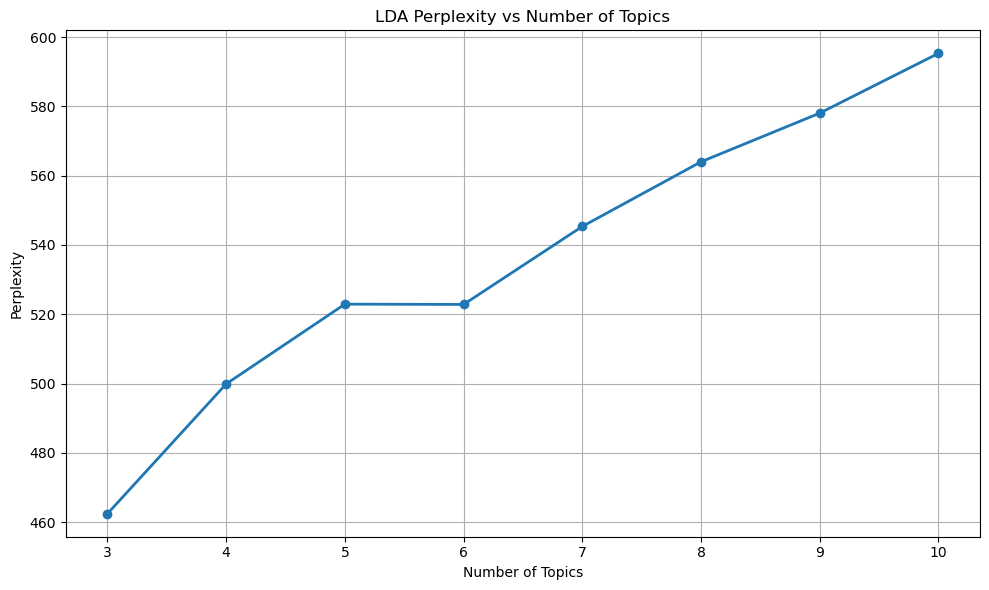

Optimal number of topics: 3

Top 10 words for each topic:
Topic 1: update, ford, app, working, new, phone, location, better, vehicle, features
Topic 2: great, love, works, good, ford, start, app, use, awesome, remote
Topic 3: start, vehicle, time, work, remote, lock, unlock, truck, like, app


In [24]:
# LDA Topic Modeling with Hyperparameter Tuning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Prepare text data
texts = df['review_text'].astype(str).tolist()



# Create CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=1000)
doc_term_matrix = vectorizer.fit_transform(texts)

# Hyperparameter tuning: test different numbers of topics
n_topics_range = range(3, 11)
coherence_scores = []
perplexity_scores = []

for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10, learning_method='online')
    lda.fit(doc_term_matrix)
    
    # Calculate perplexity (lower is better)
    perplexity = lda.perplexity(doc_term_matrix)
    perplexity_scores.append(perplexity)

# Plot perplexity scores
plt.figure(figsize=(10, 6))
plt.plot(n_topics_range, perplexity_scores, marker='o', linewidth=2)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('LDA Perplexity vs Number of Topics')
plt.grid(True)
plt.tight_layout()
plt.show()

# Fit final LDA model with optimal number of topics
optimal_topics = n_topics_range[np.argmin(perplexity_scores)]
print(f"Optimal number of topics: {optimal_topics}")

lda_final = LatentDirichletAllocation(n_components=optimal_topics, random_state=42, max_iter=20, learning_method='online')
lda_final.fit(doc_term_matrix)

# Display top words for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

print(f"\nTop {n_top_words} words for each topic:")
for topic_idx, topic in enumerate(lda_final.components_):
    top_words_idx = topic.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")